In [25]:
import os
import re
import numpy as np
import wfdb
import pickle
import scipy
from torch.utils.data import Dataset

def extract_segment_with_padding(z, k, N):
    start_idx = k - N
    end_idx = k + N + 1
    if start_idx < 0:
        padding_left = np.median(z[:end_idx])
        segment = np.concatenate([np.full(-start_idx, padding_left), z[:end_idx]])
    elif end_idx > len(z):
        padding_right = np.median(z[start_idx:])
        segment = np.concatenate([z[start_idx:], np.full(end_idx - len(z), padding_right)])
    else:
        segment = z[start_idx:end_idx]
    return segment

class MIT_BIH_Arythmia(Dataset):
    def __init__(self, N, M, dataset_dir='Datasets/files/', fs=10, output_dir="processed_data/", histogram_path=None):
        self.N = N
        self.M = M
        if histogram_path and os.path.exists(histogram_path):
            with open(histogram_path, 'rb') as f:
                self.cumulative_histogram = pickle.load(f)
            print("Załadowano histogram:", histogram_path)
        else:
            os.makedirs(output_dir, exist_ok=True)
            exclusion_lst = [str(i) for i in range(10, 11)]
            self.cumulative_histogram = []
            start_idx = 0
            for file in os.listdir(dataset_dir):
                name = re.match(r'^(.*\d\d+)\.atr$', file)
                if name and name.group(1) not in exclusion_lst:
                    print(f"Przetwarzanie: {name.group(1)}")
                    record = wfdb.rdsamp(f"{dataset_dir}{name.group(1)}")
                    annotation = wfdb.rdann(f"{dataset_dir}{name.group(1)}", 'atr')
                    signal = record[0][:, 0]
                    fs_original = record[1]["fs"]
                    num_samples_target = int(signal.shape[0] * fs / fs_original)
                    resampled_signal = scipy.signal.resample(signal, num_samples_target)
                    annotation_times_resampled = (annotation.sample * fs) / fs_original
                    data = {
                        "rec": resampled_signal,
                        "ann": {
                            "sample": annotation_times_resampled.astype(int).tolist(),
                            "aux_note": annotation.aux_note
                        }
                    }
                    output_filename = os.path.join(output_dir, f"{name.group(1)}.pkl")
                    with open(output_filename, 'wb') as f:
                        pickle.dump(data, f)
                    num_samples = len(data["ann"]["sample"])
                    self.cumulative_histogram.append((start_idx, start_idx + num_samples, output_filename))
                    start_idx += num_samples
            histogram_path = os.path.join(output_dir, "cumulative_histogram.pkl")
            with open(histogram_path, 'wb') as f:
                pickle.dump(self.cumulative_histogram, f)
            print("Przetwarzanie zakończone. Dane zapisane w:", output_dir)

    def __len__(self):
        return self.cumulative_histogram[-1][1]

    # def __getitem__(self, idx):
    #     for start, end, filename in self.cumulative_histogram:
    #         if start <= idx < end:
    #             local_idx = idx - start
    #             break
    #     else:
    #         raise IndexError("Index out of range")
    #     with open(filename, 'rb') as f:
    #         data = pickle.load(f)
    #     rec = data["rec"]
    #     sample_idx = data["ann"]["sample"][local_idx]
    #     aux_note = data["ann"]["aux_note"][local_idx]
    #     segment = extract_segment_with_padding(rec, sample_idx, self.N)
    #     label = 1 if aux_note == '(AFIB' else 0
    #     return segment, label
    def __getitem__(self, idx):
    # Przejdź przez histogram skumulowany, aby znaleźć odpowiedni plik i zakres indeksów
        for start, end, filename in self.cumulative_histogram:
            if start <= idx < end:
                local_idx = idx - start  # Oblicz indeks lokalny w danym pliku
                break
        else:
            raise IndexError("Index out of range")  # Jeśli nie znajdziesz odpowiedniego zakresu, zgłoś błąd
        
        # Załaduj dane z odpowiedniego pliku
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        # Pobierz sygnał EKG i informacje o annotacjach
        rec = data["rec"]
        sample_idx = data["ann"]["sample"][local_idx]  # Indeks próbki w danym pliku
        aux_note = data["ann"]["aux_note"][local_idx]  # Etykieta (np. AFIB lub NORMAL)
        
        # Wyciąć odpowiedni segment EKG wokół punktu annotacji
        segment = extract_segment_with_padding(rec, sample_idx, self.N)
        
        # Ustal etykietę: 1 dla AFIB, 0 dla NORMAL
        label = 1 if aux_note == '(AFIB' else 0
        
        return segment, label

    def count_afibs(self):
        afib_count = 0
        for start, end, filename in self.cumulative_histogram:
            # Załaduj dane z pliku
            with open(filename, 'rb') as f:
                data = pickle.load(f)
            
            # Sprawdź wszystkie etykiety i policz AFIB
            for aux_note in data["ann"]["aux_note"]:
                if "(AFIB" in aux_note:
                    afib_count += 1
        return afib_count
    
    def count_afibs(self):
        afib_count = 0
        for start, end, filename in self.cumulative_histogram:
            # Załaduj dane z pliku
            with open(filename, 'rb') as f:
                data = pickle.load(f)
            
            # Sprawdź wszystkie etykiety i policz AFIB
            for aux_note in data["ann"]["aux_note"]:
                if "(AFIB" in aux_note:
                    afib_count += 1
        return afib_count

    def count__not_afibs(self):
        afib_count = 0
        for start, end, filename in self.cumulative_histogram:
            # Załaduj dane z pliku
            with open(filename, 'rb') as f:
                data = pickle.load(f)
            
            # Sprawdź wszystkie etykiety i policz AFIB
            for aux_note in data["ann"]["aux_note"]:
                if "(AFIB" not in aux_note:
                    afib_count += 1
        return afib_count


In [26]:
ds = MIT_BIH_Arythmia(100,5,fs=100,dataset_dir='physionet.org/files/ltafdb/1.0.0/')

Przetwarzanie: 101
Przetwarzanie: 25
Przetwarzanie: 19
Przetwarzanie: 116
Przetwarzanie: 42
Przetwarzanie: 110
Przetwarzanie: 58
Przetwarzanie: 112
Przetwarzanie: 205
Przetwarzanie: 122
Przetwarzanie: 20
Przetwarzanie: 24
Przetwarzanie: 06
Przetwarzanie: 45
Przetwarzanie: 17
Przetwarzanie: 05
Przetwarzanie: 48
Przetwarzanie: 111
Przetwarzanie: 35
Przetwarzanie: 200
Przetwarzanie: 64
Przetwarzanie: 204
Przetwarzanie: 00
Przetwarzanie: 53
Przetwarzanie: 72
Przetwarzanie: 69
Przetwarzanie: 201
Przetwarzanie: 113
Przetwarzanie: 65
Przetwarzanie: 21
Przetwarzanie: 121
Przetwarzanie: 30
Przetwarzanie: 75
Przetwarzanie: 60
Przetwarzanie: 22
Przetwarzanie: 34
Przetwarzanie: 100
Przetwarzanie: 33
Przetwarzanie: 74
Przetwarzanie: 114
Przetwarzanie: 13
Przetwarzanie: 102
Przetwarzanie: 55
Przetwarzanie: 115
Przetwarzanie: 43
Przetwarzanie: 03
Przetwarzanie: 117
Przetwarzanie: 38
Przetwarzanie: 118
Przetwarzanie: 37
Przetwarzanie: 23
Przetwarzanie: 49
Przetwarzanie: 203
Przetwarzanie: 62
Przetwarz

In [9]:
ds[7]

(array([-1.80920419e-01, -1.87886019e-01, -1.71094582e-01, -1.75422381e-01,
        -1.21075154e-01, -2.11214783e-02,  3.26984099e-01,  4.09966285e-01,
         1.08096163e-01, -5.36241415e-02, -1.34585308e-01, -1.67034761e-01,
        -1.85654787e-01, -1.84693876e-01, -1.96240578e-01, -1.94296828e-01,
        -2.01947176e-01, -1.89263046e-01, -1.59897901e-01, -1.75522421e-01,
        -1.56267666e-01, -1.63724781e-01, -1.17240218e-01, -1.00394377e-01,
        -6.35989552e-02, -5.65785919e-02,  8.05510398e-04,  5.21243145e-02,
         8.81517655e-02,  1.43967229e-01,  1.86545818e-01,  2.45467441e-01,
         2.64598292e-01,  2.83127739e-01,  2.68716921e-01,  2.51028287e-01,
         1.95043746e-01,  1.15671605e-01,  5.47469707e-02, -2.59107093e-02,
        -4.13080978e-02, -9.06302535e-02, -1.08586610e-01, -1.26123670e-01,
        -1.40026424e-01, -1.29399617e-01, -1.40629107e-01, -1.47295787e-01,
        -1.61834673e-01, -1.27796788e-01, -1.26506303e-01, -1.22751849e-01,
        -1.3

In [ ]:
# from torch.utils.data import DataLoader

# # Stwórz dataset
# dataset = MIT_BIH_Arythmia(N=100, M=50, histogram_path="processed_data/cumulative_histogram.pkl")

# # Stwórz DataLoader
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# # Iteracja po danych
# for batch_idx, (segments, labels) in enumerate(dataloader):
#     print(f"Batch {batch_idx}:")
#     print(f"  - Rozmiar segmentów: {segments.shape}")
#     print(f"  - Rozmiar etykiet: {labels.shape}")


Załadowano histogram: processed_data/cumulative_histogram.pkl
Batch 0:
  - Rozmiar segmentów: torch.Size([32, 201])
  - Rozmiar etykiet: torch.Size([32])
Batch 1:
  - Rozmiar segmentów: torch.Size([32, 201])
  - Rozmiar etykiet: torch.Size([32])
Batch 2:
  - Rozmiar segmentów: torch.Size([32, 201])
  - Rozmiar etykiet: torch.Size([32])
Batch 3:
  - Rozmiar segmentów: torch.Size([32, 201])
  - Rozmiar etykiet: torch.Size([32])


KeyboardInterrupt: 

In [ ]:
ds.count_afibs()/ds.count__not_afibs()

0.0008139530202152915

8941548

In [22]:
import pickle

# Załaduj dane z pliku pickle
with open('processed_data/cumulative_histogram.pkl', 'rb') as f:
    data = pickle.load(f)

# Sprawdź pierwsze elementy
print(data)  # Powinna to być lista lub słownik z segmentami i etykietami


[(0, 99533, 'processed_data/101.pkl'), (99533, 210189, 'processed_data/25.pkl'), (210189, 318253, 'processed_data/19.pkl'), (318253, 431527, 'processed_data/116.pkl'), (431527, 545974, 'processed_data/42.pkl'), (545974, 651435, 'processed_data/110.pkl'), (651435, 761540, 'processed_data/58.pkl'), (761540, 879828, 'processed_data/112.pkl'), (879828, 996330, 'processed_data/205.pkl'), (996330, 1087214, 'processed_data/122.pkl'), (1087214, 1195213, 'processed_data/20.pkl'), (1195213, 1292639, 'processed_data/24.pkl'), (1292639, 1397578, 'processed_data/06.pkl'), (1397578, 1493732, 'processed_data/45.pkl'), (1493732, 1631793, 'processed_data/17.pkl'), (1631793, 1744756, 'processed_data/05.pkl'), (1744756, 1891543, 'processed_data/48.pkl'), (1891543, 1994169, 'processed_data/111.pkl'), (1994169, 2083335, 'processed_data/35.pkl'), (2083335, 2165990, 'processed_data/200.pkl'), (2165990, 2285771, 'processed_data/64.pkl'), (2285771, 2422559, 'processed_data/204.pkl'), (2422559, 2528896, 'proces

In [36]:
def extract_afib_samples(dataset, num_samples=5):
    afib_samples = []
    
    for idx in range(len(dataset)):
        segment, label = dataset[idx]
        if idx % 10000 == 0:
            print(idx)
        
        # Sprawdź, czy etykieta to AFIB (1 oznacza AFIB)
        if label == 1:
            afib_samples.append(segment)
            print("idx:",idx)
        
        # Jeśli już mamy wystarczającą liczbę próbek AFIB, zakończ
        if len(afib_samples) >= num_samples:
            break
    
    return afib_samples

# Pobierz 5 próbek AFIB
afib_samples = extract_afib_samples(ds, num_samples=5)


0
idx: 470
10000
idx: 19353
20000
idx: 21576
idx: 22000
idx: 22329


In [30]:
print(len(ds))

8948826


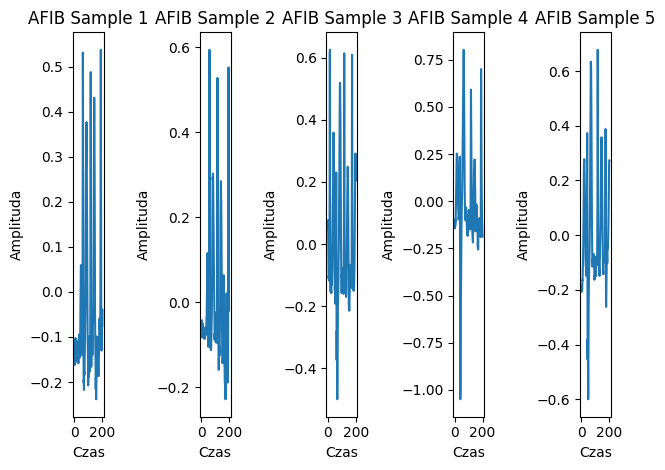

In [37]:
import matplotlib.pyplot as plt

def plot_afib_samples(afib_samples):
    for i, sample in enumerate(afib_samples):
        plt.subplot(1, len(afib_samples), i + 1)
        plt.plot(sample)
        plt.title(f"AFIB Sample {i+1}")
        plt.xlabel("Czas")
        plt.ylabel("Amplituda")
    plt.tight_layout()
    plt.show()

# Wyświetl próbek
plot_afib_samples(afib_samples)
